# Social distancing detection

![](https://github.com/lucasresck/deep-learning-and-applications/blob/main/images/social_distance_detection.gif?raw=true)

I present the use of YOLOv5 for people detection, and two ways to use this model to build a **social distance detection tool**.

- The first way is to detect people and calculate the distance among people using the distance among the **centers of the detection boxes**.
- The second way, cooler, is to apply **perspective** in order to calculate the real distance among people.

Lucas Emanuel Resck Domingues

[Deep Learning and Applications](https://emap.fgv.br/sites/emap.fgv.br/files/ementa_deep_learning_and_applications.pdf) summer course

Escola de Matemática Aplicada da Fundação Getulio Vargas (FGV-EMAp)

Professor: Cristian Jose Lopez Del Alamo (Universidad la Salle - Peru)



## Setup

We import various libraries.

In [ ]:
from base64 import b64encode
from google.colab import files
from google.colab.patches import cv2_imshow
from IPython.display import HTML
from PIL import Image
from tqdm.notebook import tqdm
import cv2
import numpy as np
import os
import torch

## Data

We use a recording from the CVLab - EPFL (check the references at the end).

In [ ]:
# It may take a while...
!wget "https://documents.epfl.ch/groups/c/cv/cvlab-pom-video1/www/campus4-c0.avi"

--2022-01-07 22:48:18--  https://documents.epfl.ch/groups/c/cv/cvlab-pom-video1/www/campus4-c0.avi
Resolving documents.epfl.ch (documents.epfl.ch)... 128.178.222.197, 2001:620:618:1de:1:80b2:dec5:1
Connecting to documents.epfl.ch (documents.epfl.ch)|128.178.222.197|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 33448124 (32M) [application/octet-stream]
Saving to: ‘campus4-c0.avi’

campus4-c0.avi      100%[===================>]  31.90M  1.47MB/s    in 29s     

2022-01-07 22:48:49 (1.11 MB/s) - ‘campus4-c0.avi’ saved [33448124/33448124]



In [ ]:
def display_video(path):
    '''Display video in Colab.'''
    compressed_path = path.split('.')[0]
    compressed_path = 'compressed_' + compressed_path + '.mp4'

    if os.path.exists(compressed_path):
        os.remove(compressed_path)

    # Convert video
    os.system(f"ffmpeg -i {path} -vcodec libx264 {compressed_path}")

    #Show video
    mp4 = open(compressed_path,'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
    return HTML("""
    <video width=400 controls>
      <source src="%s" type="video/mp4">
    </video>
    """ % data_url)

Let's watch the video.

In [ ]:
filename = 'pedestrians.mp4'
# filename = 'campus4-c0.avi'
# display_video(filename)

## Model

The model used is YOLOv5x, the best YOLOv5 model.
We import it with Torch Hub.

When we pass an image to this model, it returns to us where objects are in the image, which objects they are, and what is the model's confidence about this.

In [ ]:
# Load model
model = torch.hub.load('ultralytics/yolov5', 'yolov5x',
                       pretrained=True, verbose=False)
model.cuda('cuda:0');
# model.cpu()

requirements: PyYAML>=5.3.1 not found and is required by YOLOv5, attempting auto-update...


YOLOv5 🚀 2022-1-7 torch 1.10.0+cu111 CUDA:0 (Tesla K80, 11441MiB)




requirements: 1 package updated per /root/.cache/torch/hub/ultralytics_yolov5_master/requirements.txt
requirements: ⚠️ Restart runtime or rerun command for updates to take effect



  0%|          | 0.00/14.0M [00:00<?, ?B/s]

Fusing layers... 


Model Summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


## People detection

The first way to calculate distance among people is just calculate the distance among the rectangles (boxes) returned by the model, more precisely the distance among their centers.

In [ ]:
def center_distance(xyxy1, xyxy2):
    '''Calculate the distance of the centers of the boxes.'''
    a, b, c, d = xyxy1
    x1 = int(np.mean([a, c]))
    y1 = int(np.mean([b, d]))

    e, f, g, h = xyxy2
    x2 = int(np.mean([e, g]))
    y2 = int(np.mean([f, h]))
    
    dist = np.linalg.norm([x1 - x2, y1 - y2])
    return dist, x1, y1, x2, y2

When we have a frame of a video, we can detect the people on the frame using YOLOv5x and draw the rectangles.
The color of the rectangle indicates if the person is too close to another person.

In [ ]:
def detect_people_on_frame(img, confidence, distance):
    '''Detect people on a frame and draw the rectangles and lines.'''
    results = model([img[:, :, ::-1]])  # Pass the frame through the model and get the boxes

    xyxy = results.xyxy[0].cpu().numpy()  # xyxy are the box coordinates
    #          x1 (pixels)  y1 (pixels)  x2 (pixels)  y2 (pixels)   confidence        class
    # tensor([[7.47613e+02, 4.01168e+01, 1.14978e+03, 7.12016e+02, 8.71210e-01, 0.00000e+00],
    #         [1.17464e+02, 1.96875e+02, 1.00145e+03, 7.11802e+02, 8.08795e-01, 0.00000e+00],
    #         [4.23969e+02, 4.30401e+02, 5.16833e+02, 7.20000e+02, 7.77376e-01, 2.70000e+01],
    #         [9.81310e+02, 3.10712e+02, 1.03111e+03, 4.19273e+02, 2.86850e-01, 2.70000e+01]])

    xyxy = xyxy[xyxy[:, 4] >= confidence]  # Filter desired confidence
    xyxy = xyxy[xyxy[:, 5] == 0]  # Consider only people
    xyxy = xyxy[:, :4]

    colors = ['green']*len(xyxy)
    for i in range(len(xyxy)):
        for j in range(i+1, len(xyxy)):
            # Calculate distance of the centers
            dist, x1, y1, x2, y2 = center_distance(xyxy[i], xyxy[j])
            if dist < distance:
                # If dist < distance, boxes are red and a line is drawn
                colors[i] = 'red'
                colors[j] = 'red'
                img = cv2.line(img, (x1, y1), (x2, y2), (0, 0, 255), 2)
    for i, (x1, y1, x2, y2) in enumerate(xyxy):
        # Draw the boxes
        if colors[i] == 'green':
            color = (0, 255, 0)
        else:
            color = (0, 0, 255)
        img = cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)
    return img

To detect people in a video, we iterate through all frames of the video, and save a new video with the rectangles drawn.

In [ ]:
def detect_people_on_video(filename, confidence=0.9, distance=60):
    '''Detect people on a video and draw the rectangles and lines.'''
    # Capture video
    cap = cv2.VideoCapture(filename)

    # Get video properties
    fps = cap.get(cv2.CAP_PROP_FPS)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Define the codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    if os.path.exists('output.avi'):
        os.remove('output.avi')
    out = cv2.VideoWriter('output.avi', fourcc, fps, (width, height))

    # Iterate through frames and detect people
    vidlen = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    with tqdm(total=vidlen) as pbar:
        while cap.isOpened():
            # Read a frame
            ret, frame = cap.read()
            # If it's ok
            if ret == True:
                frame = detect_people_on_frame(frame, confidence, distance)
                # Write new video
                out.write(frame)
                pbar.update(1)
            else:
                break
    # Release everything if job is finished
    cap.release()
    out.release()
    cv2.destroyAllWindows()

Let's apply the detection tool.

In [ ]:
detect_people_on_video(filename, confidence=0.5,distance=100)

  0%|          | 0/531 [00:00<?, ?it/s]

Let's watch the result.

In [ ]:
display_video('output.avi')

## Bird's-eye view

In order to remediate the problem with the centers distance calculation, we can apply **perspective**, usually called "bird's-eye view".

For example, consider the first frame of our video:

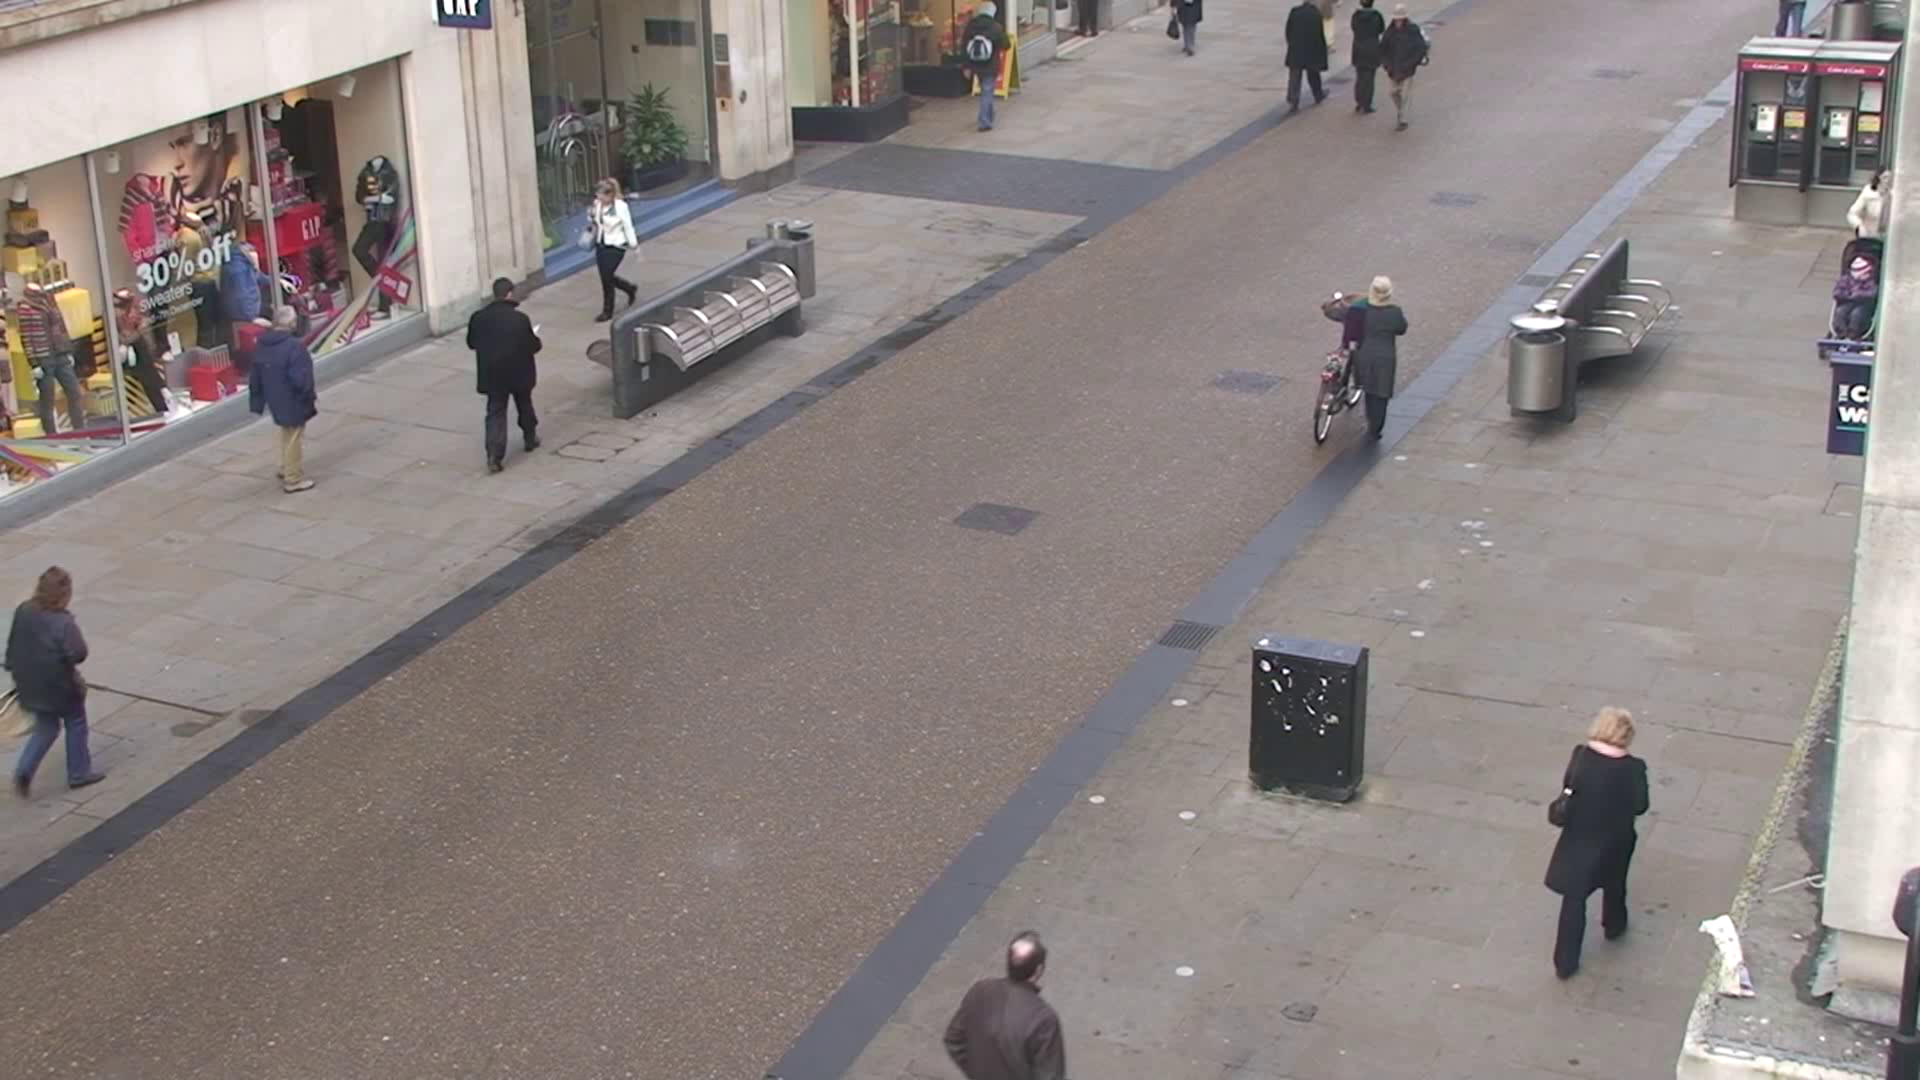

In [ ]:
filename2 = 'campus4-c0.avi'
cap = cv2.VideoCapture(filename)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
ret, image = cap.read()
if ret:
    cv2_imshow(image)

We take an quadrangular region of our image that we believe is a rectangle in real life.
For example, if we use an image editor we can gather the four points bellow, resulting in the following quadrilateral (red):

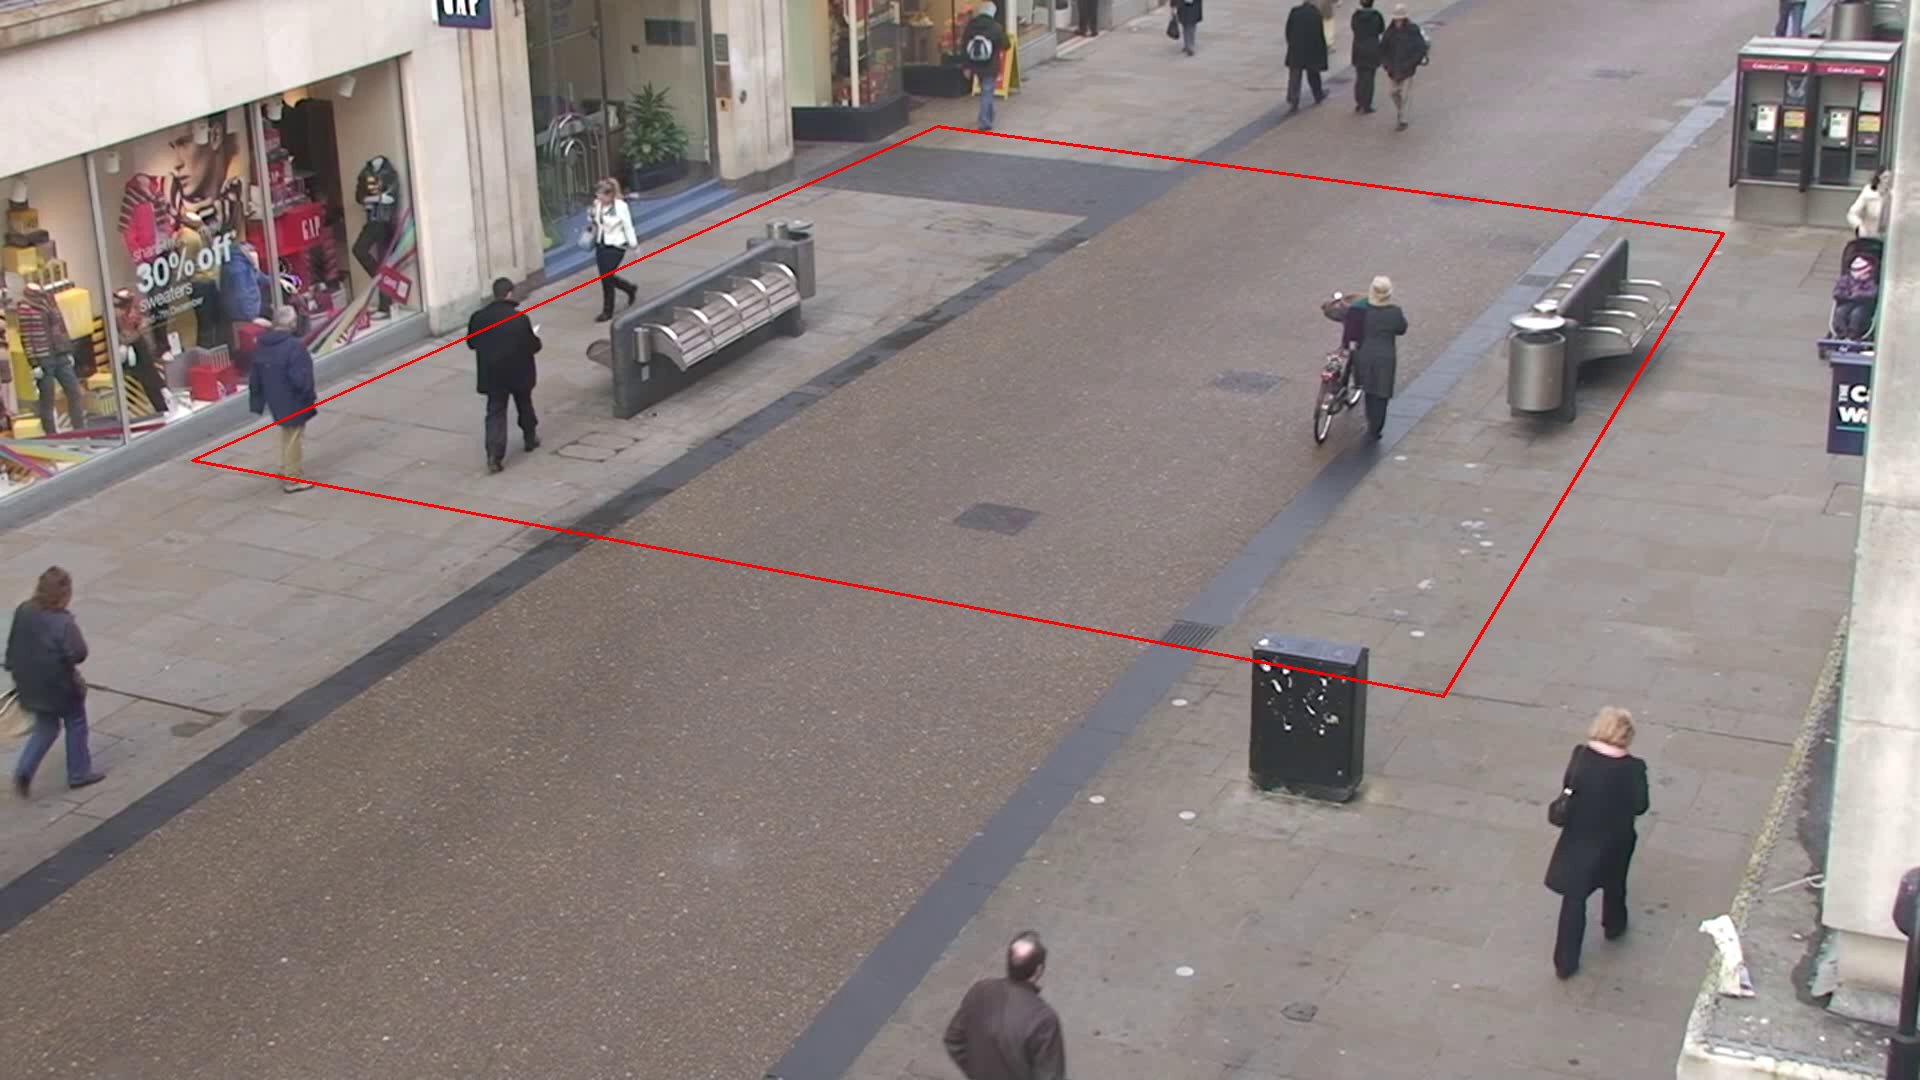

In [ ]:
# region = [[222, 129], [width, height], [0, height], [144, 130]]
region = [[192, 460], [1443, 696], [1723, 233], [937, 126]]
region = np.array(region, dtype=np.int32).reshape((-1, 1, 2))
region_image = cv2.polylines(image.copy(), [region], True, (0, 0, 255), 2)
cv2_imshow(region_image)

Now we take this quadrilateral and build a perspective transformation to a rectangle that we believe is similar to the real rectangle. It is like if we were watching it from above, like a bird.

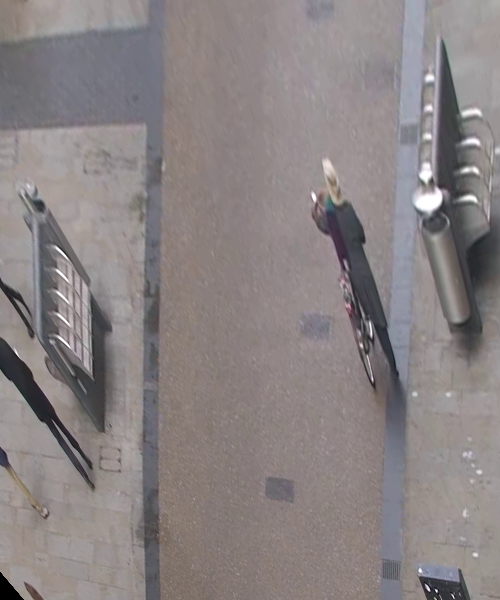

In [ ]:
region = np.array(region.reshape(4, 2), np.float32)
# dst = np.float32([[150, 0], [150, 300], [0, 300], [0, 0]])

dst = np.float32([[0, 500], [500, 600], [500, 0], [0, 0]])

M = cv2.getPerspectiveTransform(region, dst)
warped = cv2.warpPerspective(image, M, (500, 600))
cv2_imshow(warped)

In this new "image", we can calculate the usual Euclidean distance.

To make all things even cooler, we can draw a circle around the person in the transformed image, and transform it back to have the circle in perspective.
For example, suppose we have a circle in the following image:

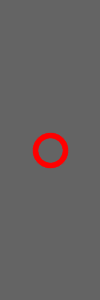

In [ ]:
overlay = np.zeros((300, 100, 3), np.uint8)
overlay[:,:,:] = 100
overlay = cv2.circle(overlay, (50, 150), 15, (0, 0, 255), 3, lineType=cv2.LINE_AA)
cv2_imshow(overlay)

If we apply the pespective, it will look like this:

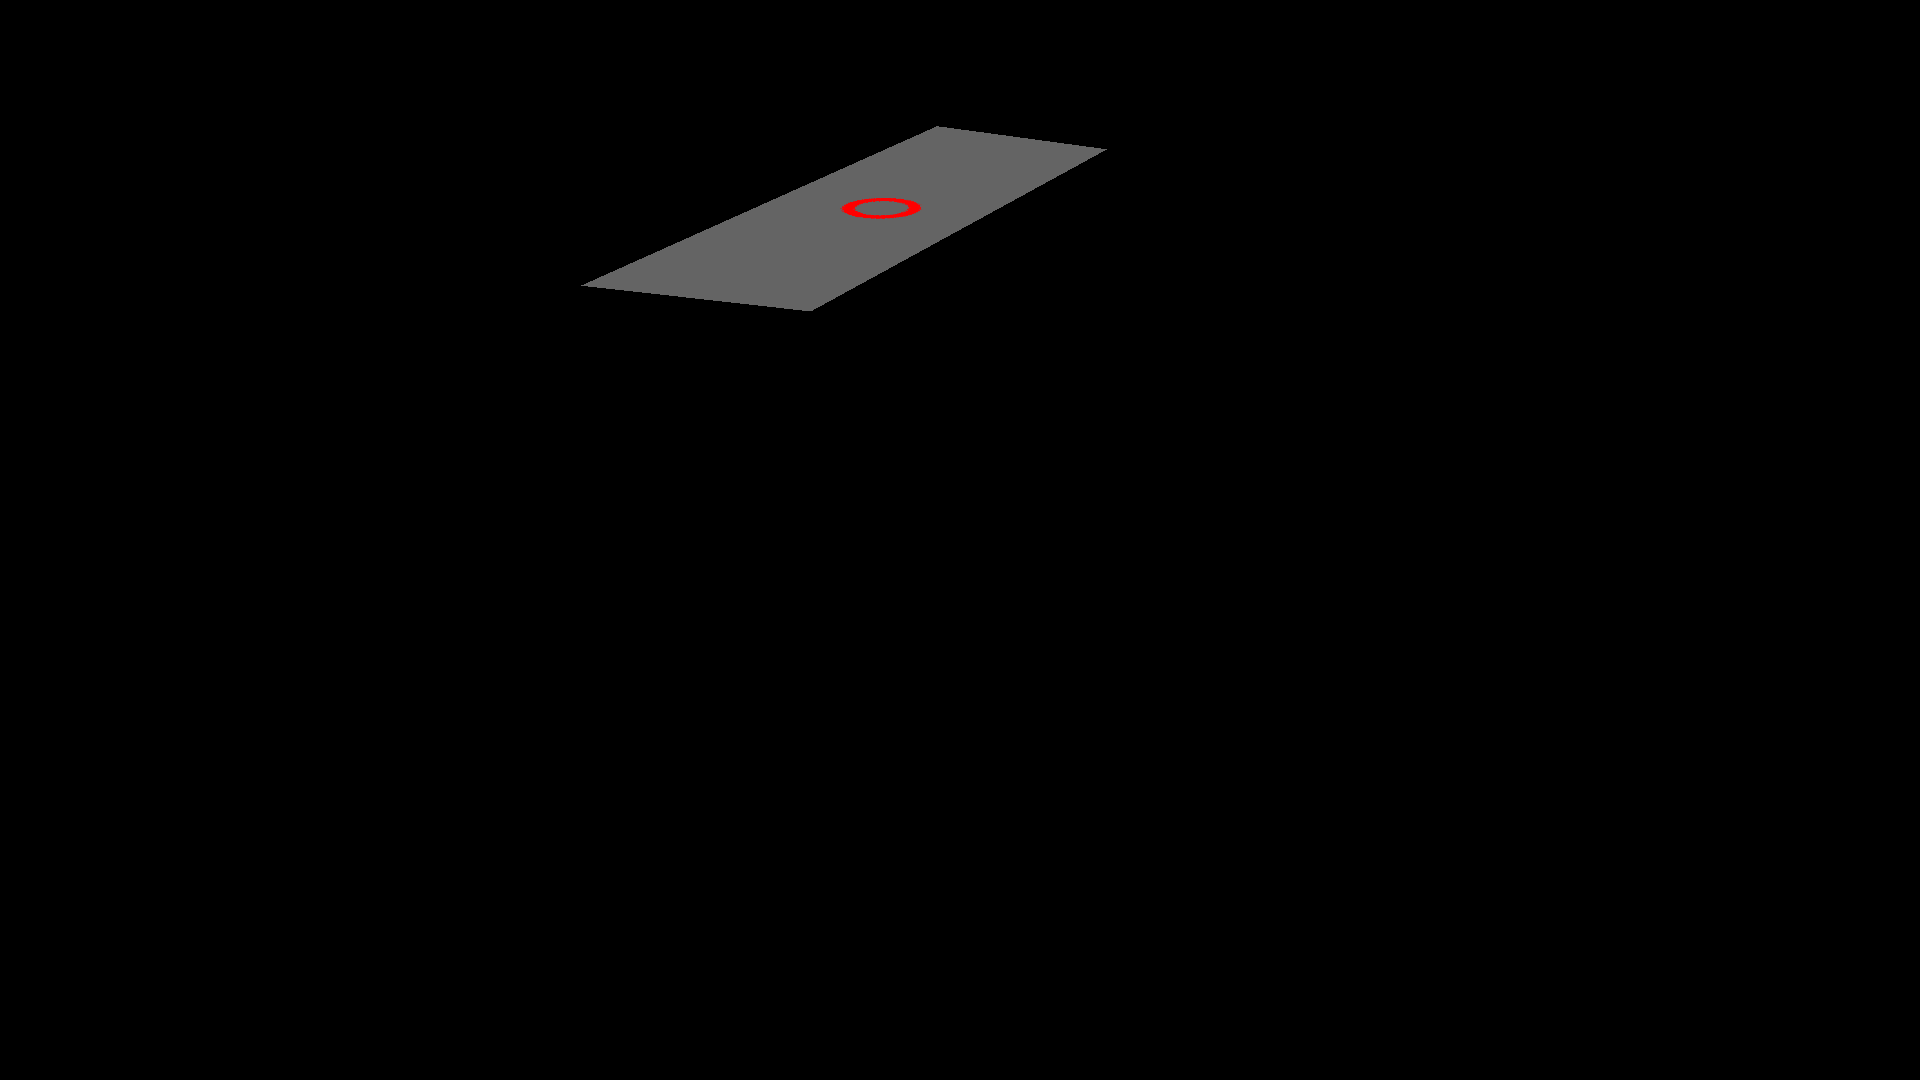

In [ ]:
overlay = cv2.warpPerspective(overlay, M, (width, height), cv2.INTER_NEAREST, cv2.WARP_INVERSE_MAP)
cv2_imshow(overlay)

This way, we can overlay this image over the original image, to have the circle drawn on the video.

If the image is bigger, the transformation is still applied, but extending it right and bottom:

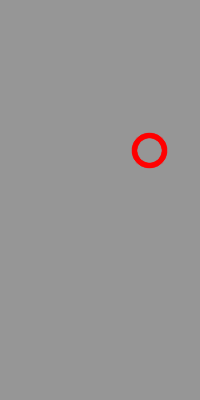

In [ ]:
overlay = np.zeros((400, 200, 3), np.uint8)
overlay[:,:,:] = 150
overlay = cv2.circle(overlay, (50, 150), 15, (0, 0, 255), 3, lineType=cv2.LINE_AA)
overlay = cv2.flip(overlay, 1)
cv2_imshow(overlay)

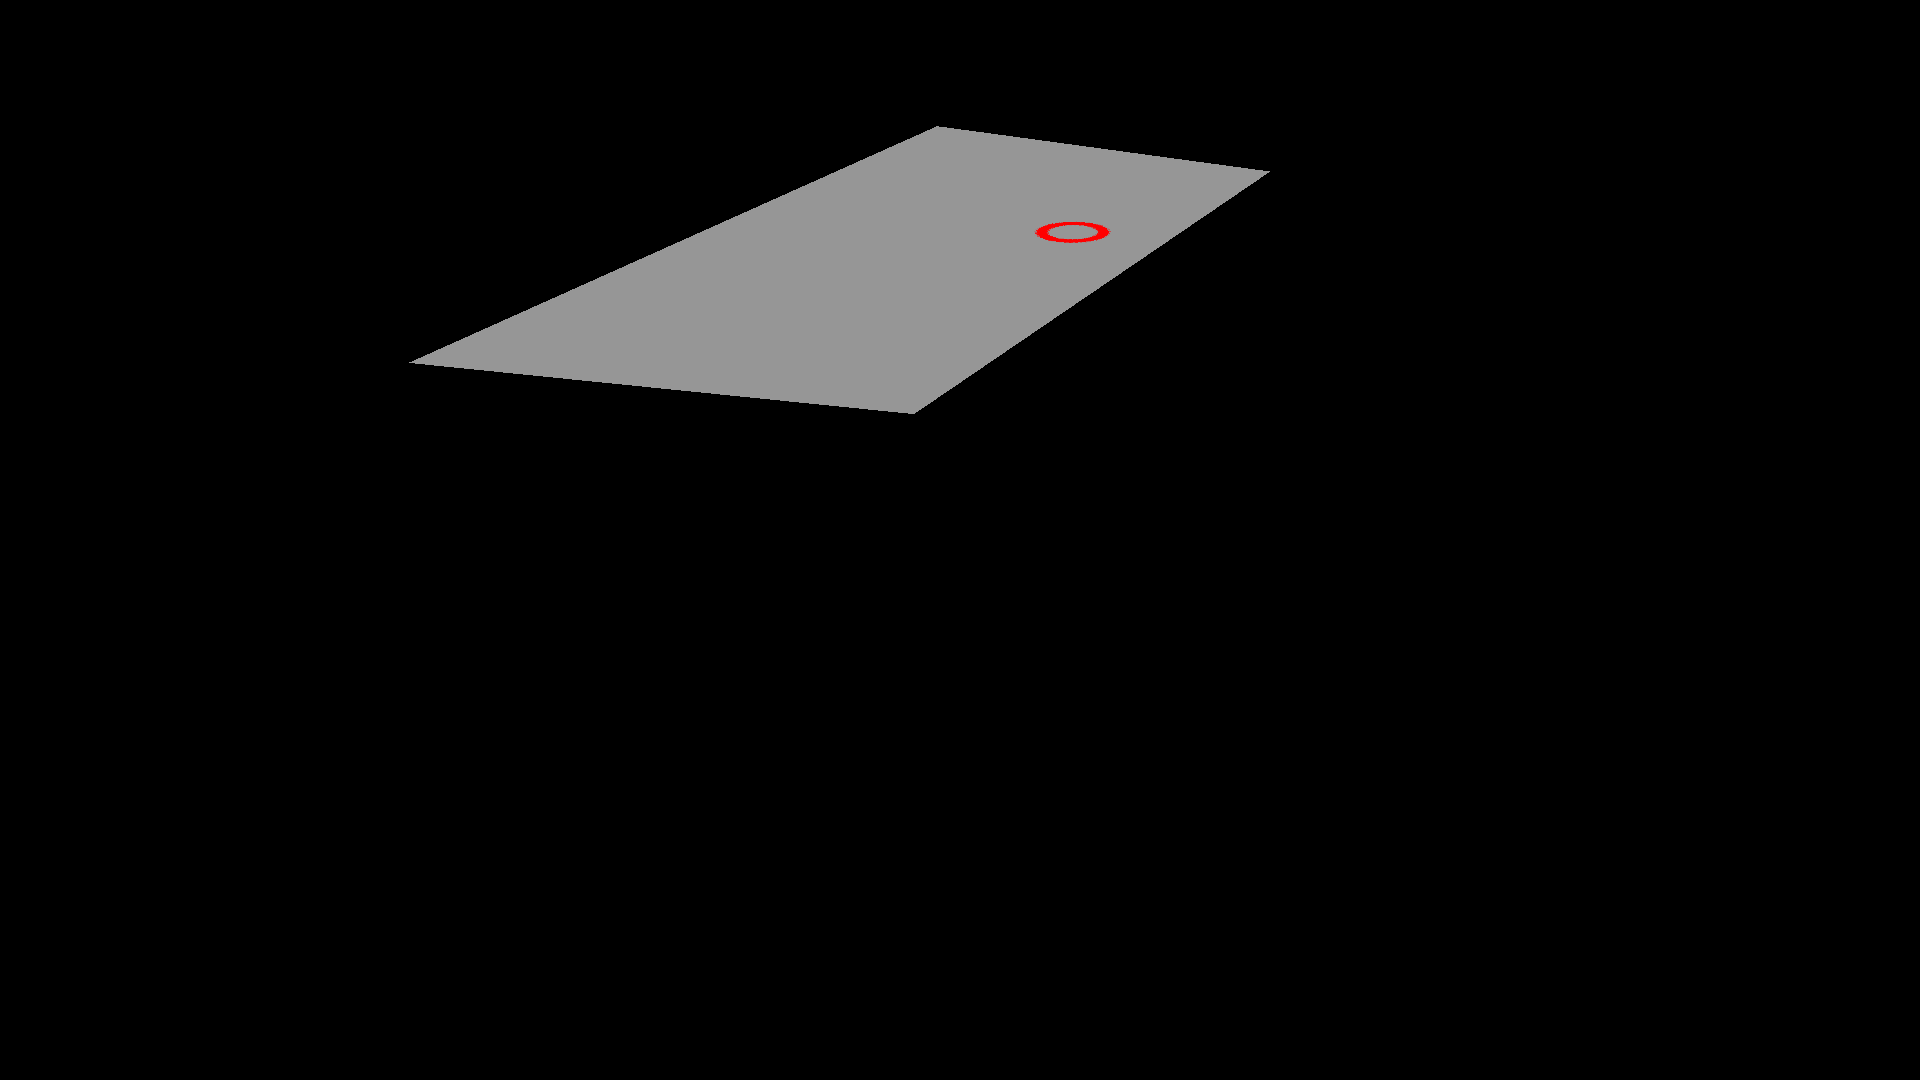

In [ ]:
overlay = cv2.warpPerspective(overlay, M, (width, height), cv2.INTER_NEAREST, cv2.WARP_INVERSE_MAP)
cv2_imshow(overlay)

In order to draw circles at left, we will use two transformations, one of them flipped.

There are various functions.
Fell free to take a look at the details :)

In [ ]:
def calculate_distance(point1, point2):
    '''Calculate usual distance.'''
    x1, y1 = point1
    x2, y2 = point2
    return np.linalg.norm([x1 - x2, y1 - y2])

In [ ]:
def convert_to_bird(centers, M):
    '''Apply the perpective to the bird's-eye view.'''
    centers = [cv2.perspectiveTransform(np.float32([[center]]), M) for center in centers.copy()]
    centers = [list(center[0, 0]) for center in centers.copy()]
    return centers

In [ ]:
def bird_detect_people_on_frame(img, confidence, distance, width, height,
                                region=None, dst=None):
    results = model([img[:, :, ::-1]])  # Pass the frame through the model and get the boxes

    xyxy = results.xyxy[0].cpu().numpy()  # xyxy are the box coordinates
    #          x1 (pixels)  y1 (pixels)  x2 (pixels)  y2 (pixels)   confidence        class
    # tensor([[7.47613e+02, 4.01168e+01, 1.14978e+03, 7.12016e+02, 8.71210e-01, 0.00000e+00],
    #         [1.17464e+02, 1.96875e+02, 1.00145e+03, 7.11802e+02, 8.08795e-01, 0.00000e+00],
    #         [4.23969e+02, 4.30401e+02, 5.16833e+02, 7.20000e+02, 7.77376e-01, 2.70000e+01],
    #         [9.81310e+02, 3.10712e+02, 1.03111e+03, 4.19273e+02, 2.86850e-01, 2.70000e+01]])

    xyxy = xyxy[xyxy[:, 4] >= confidence]  # Filter desired confidence
    xyxy = xyxy[xyxy[:, 5] == 0]  # Consider only people
    xyxy = xyxy[:, :4]

    # Calculate the centers of the circles
    # They will be the centers of the bottom of the boxes
    centers = []
    for x1, y1, x2, y2 in xyxy:
        center = [np.mean([x1, x2]), y2] # toa do center = ((x1+x2)/2) và y2
        centers.append(center)
    

    # We create two transformations
    if region is None:
        # The region on the original image
        # region = np.float32([[144, 130], [222, 129], [width, height], [0, height]])
        region = np.float32([[192, 460], [1443, 696], [1723, 233], [937, 126]])
    if dst is None:
        # The rectangle we want the image to be trasnformed to
        # dst = np.float32([[0, 0], [width, 0], [width, 3*width], [0, 3*width]])
        dst = np.float32([[500, 0], [500, 600], [0, 500], [0, 0]])
    # The first transformation is straightforward: the region to the rectangle
    # as thin the example before
    M = cv2.getPerspectiveTransform(region, dst)

    # The second transformation is a trick, because, using the common transformation,
    # we can't draw circles at left of the region.
    # This way, we flip all things and draw the circle at right of the region,
    # because we can do it.
    region_flip = region*np.float32([-1, 1]) + np.float32([width, 0])
    dst_flip = dst*np.float32([-1, 1]) + np.float32([width, 0])
    M_flip = cv2.getPerspectiveTransform(region_flip, dst_flip)

    # Convert to bird
    # Now, the center of the circles will be positioned on the rectangle
    # and we can calculate the usual distance
    bird_centers = convert_to_bird(centers, M)

    # We verify if the circles colide
    # If so, they will be red
    colors = ['green']*len(bird_centers)
    for i in range(len(bird_centers)):
        for j in range(i+1, len(bird_centers)):
            dist = calculate_distance(bird_centers[i], bird_centers[j])
            if dist < distance:
                colors[i] = 'red'
                colors[j] = 'red'

    # We draw the circles
    # Because we have two transformation, we will start with two empty
    # images ("overlay" images) to draw the circles
    overlay = np.zeros((3*width, 4*width, 3), np.uint8)
    overlay_flip = np.zeros((3*width, 4*width, 3), np.uint8)
    for i, bird_center in enumerate(bird_centers):
        if colors[i] == 'green':
            color = (0, 255, 0)
        else:
            color = (0, 0, 255)
        x, y = bird_center
        x = int(x)
        y = int(y)
        ban_kinh = 30
        do_day = 5
        # if x >= int(distance/2 + do_day/2):
        # if x >= int(width/2):
        if x >= int(distance/2+15/2):
            # If it's the case the circle is inside or at right of our region
            # we can use the normal overlay image
            overlay = cv2.circle(overlay, (x, y), ban_kinh,color, do_day, lineType=cv2.LINE_AA)
        else:
            # If the circle is at left of the region,
            # we draw the circle inverted on the other overlay image
            x = width - x
            overlay_flip = cv2.circle(overlay_flip, (x, y), ban_kinh,color, do_day, lineType=cv2.LINE_AA)

    # We apply the inverse transformation to the overlay
    overlay = cv2.warpPerspective(overlay, M, (width, height),
                                  cv2.INTER_NEAREST, cv2.WARP_INVERSE_MAP)
    # We apply the inverse of the other transformation to the other overlay
    overlay_flip = cv2.warpPerspective(overlay_flip, M_flip, (width, height),
                                       cv2.INTER_NEAREST, cv2.WARP_INVERSE_MAP)
    # Now we "unflip" what the second overlay
    overlay_flip = cv2.flip(overlay_flip, 1)

    # We add all images
    img = cv2.addWeighted(img, 1, overlay, 1, 0)
    img = cv2.addWeighted(img, 1, overlay_flip, 1, 0)

    return img

In [ ]:
def bird_detect_people_on_video(filename, confidence=0.9, distance=160):
    # Capture video
    cap = cv2.VideoCapture(filename)

    # Get video properties
    fps = cap.get(cv2.CAP_PROP_FPS)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Define the codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    if os.path.exists('bird_output.avi'):
        os.remove('bird_output.avi')
    out = cv2.VideoWriter('bird_output.avi', fourcc, fps, (width, height))

    # Iterate through frames
    vidlen = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    with tqdm(total=vidlen) as pbar:
        while cap.isOpened():
            # Read frame
            ret, frame = cap.read()
            if ret == True:
                # Detect people as a bird
                frame = bird_detect_people_on_frame(frame, confidence, distance,
                                                    width, height)
                # Write frame to new video
                out.write(frame)
                pbar.update(1)
            else:
                break

    # Release everything if job is finished
    cap.release()
    out.release()
    cv2.destroyAllWindows()

Let's check the result:

In [ ]:
bird_detect_people_on_video(filename, confidence=0.5, distance=70)

  0%|          | 0/531 [00:00<?, ?it/s]

In [ ]:
display_video('bird_output.avi')

## References

### The video

Multi-Camera People Tracking with a Probabilistic Occupancy Map
F. Fleuret; J. Berclaz; R. Lengagne; P. Fua 

IEEE Transactions on Pattern Analysis and Machine Intelligence. 2008. Vol. 30, num. 2, p. 267-282. DOI : 10.1109/TPAMI.2007.1174.

https://www.epfl.ch/labs/cvlab/data/data-pom-index-php/

### The model

https://github.com/ultralytics/yolov5/issues/36

